In [5]:
%config InlineBackend.figure_format = 'svg' # change output plot display format to 'svg'

# import the required modules for this notebook
import numpy
import matplotlib.pyplot as plt

# import the helper functions from the parent directory,
# these help with things like graph plotting and notebook layout
import sys
sys.path.append('..')
from helper_functions import *

# set things like fonts etc - comes from helper_functions
set_notebook_preferences()

# add a show/hide code button - also from helper_functions
toggle_code(title = "setup code")

## Mixture of Gaussians and the Expectation Maximisation Algorithm

In the previous section we saw how k-means is used in clustering, highlighting a pathological example where an anisotropic group of points led to unexpected clusters. We also discussed the issue of hard cluster assignments in k-means, and we alluded to an approach in which instead of using hard assignments, we work in terms of probabilities that a given point belongs to a certain cluster. In this section we introduce the mixture of gaussians (MoG) model which addresses the problem of clusters with unequal lenghtscales as well as the problem of hard assignments.

Starting off by writing down the generative model for the MoG:

1. Each datapoint may belong to one of $K$ clusters. Using the notation $s_n = 1, 2, ... K$ to denote that the $n^{th}$ datpoint belongs to the $1^{st}, 2^{nd}, ... K^{th}$ cluster, we sample $s_n$ from a discrete probabitity distribution $p(s_n = k | \{\pi\}) = \pi_k$.

2. Each cluster is a multivariate gaussian with mean $\boldsymbol{\mu}_k$ and covariance $\boldsymbol{\Sigma}_k$. Given the membership $s_n = k$, we sample $\boldsymbol{\mathbf{x}}_n$ from the corresponding mulivatiate gaussian: $p(\mathbf{x}_n| s_n = k) = \mathcal{N}(\mathbf{x}_n; \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$. The sampled $\{\boldsymbol{\mathbf{x}}_n\}$ are the observed datapoints.

Put plainly, each datapoint is generated by sampling from a discrete distribution $\{\pi_k\}_{k = 1}^K$ over clusters and then sampling the location of that datapoint given its cluster's parameters $(\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$.

The variables $s_n$ are called latent variables, because they are not directly observed. When using an MoG to model a certain dataset, which may or may not have been generated by an MoG itself, we are assuming the cluster memberships $s_n$ exist, however they are not directly observed but are hidden from us, hence the nomenclature latent. 

To illustrate the generative process, we'll create some synthetic data using an MoG model $-$ in particular we will generate the pathological dataset of the previous section.

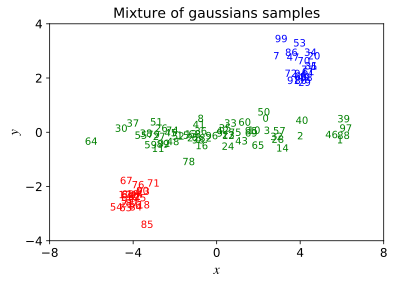

In [6]:
np.random.seed(0)

cov_1,cov_2, cov_3 = np.array([[0.2, 0], [0, 0.2]]), np.array([[10, 0], [0, 0.1]]), np.array([[0.2, 0], [0, 0.2]])
covs = np.stack([cov_1, cov_2, cov_3], axis = 0)

mu_1, mu_2, mu_3 = np.array([[-4, -2.5]]).T, np.array([[0, 0]]).T, np.array([[4, 2.5]]).T
mus = np.stack([mu_1, mu_2, mu_3], axis = 0)

xs = []
ss = []
for n in range(100):

    s = np.random.choice([0, 1, 2], p = [0.25, 0.5, 0.25])
    mu, cov = np.reshape(mus[s], (-1)), covs[s]
    xs.append(np.random.multivariate_normal(mu, cov))
    ss.append(s)

xs, ss = np.array(xs), np.array(ss)
for i, x_ in enumerate(xs):
    plt.text(x_[0], x_[1], s = i, color = ['r', 'g', 'b'][ss[i]], ha = "center", va = "center")
plt.xticks(np.arange(-8, 9, 4)), plt.yticks(np.arange(-4, 5, 2))
beautify_plot({"title":"Mixture of gaussians samples", "x":"$x$", "y":"$y$"})
plt.show()

The aim now is given a dataset $\{\mathbf{x}_n\}$, to infer the cluster memberships $s_n$ and model parameters $\{\pi_k, \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k\}$ $-$ for which we will adopt a maximum-likelihood approach. Using the shorthand $\theta = \{\pi_k, \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k\}$ and defining $\mathbf{X}$ as the matrix in which the $n^{th}$ row is $\mathbf{x}_n$, we therefore seek to maximise the likelihood with respect to $\theta$. Defining the $1$-of-$K$ indicator variable $z_{nk}$ in the usual way, the likelihood can be written as

\begin{align}
p(\mathbf{X}| \mathbf{Z}, \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) = \prod^K_{k = 1}\prod^N_{n = 1} \bigg[\pi_k\text{exp}\big({-\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top}\boldsymbol{\Sigma}^{-1}_k(\mathbf{x}_n - \boldsymbol{\mu}_k)\big)\bigg]^{z_{nk}}
\end{align}

However, we have run into trouble at this point, because an exact closed form solution does not exist for the maximisation of the likelihood with respect to $\theta = \{\pi_k, \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k\}$.

We must therefore find an approximate solution to maximising $p(\mathbf{X}|\theta)$. To achieve this we will use the Expectation Maximisation, or EM algorithm. Because the subsequent discussion may appear long-winded and in order to prevent getting disoriented by the maths, here is a summary of the approach:

1. Define a quantity $\mathcal{F}$, which is a lower bound to the log-likelihood $\mathcal{F} \leq \text{log}~p(\mathbf{X}|\theta)$. This quantity $\mathcal{F}(q(\mathbf{s}), \theta)$ depends on a probability distribution $q(\mathbf{s})$ which we choose arbitrarily and on the model parameters $\theta$.

2. Pick an initial probability distribution $q_0(\mathbf{s})$ and an initial set of model parameters $\theta_0$.

3. For fixed parameters $\theta_n$, maximise $\mathcal{F}(q(\mathbf{s}), \theta_n)$ with respect to $q(\mathbf{s})$. Call probability distribution which maximises this, $q_{n+1}(\mathbf{s})$. This maximisation increases the lower bound on the log-likelihood because $\mathcal{F}(q_n(\mathbf{s}), \theta_n) \leq \mathcal{F}(q_{n+1}(\mathbf{s}), \theta_n) \leq \text{log}~p(\mathbf{X}|\theta_n)$. This called the Expectation or E step.

4. For fixed probability distribution $q_{n+1}(\mathbf{s})$, maximise $\mathcal{F}(q_{n+1}(\mathbf{s}), \theta)$ with respect to $\theta$. Call the set of parameters which maximises the free energy $\theta_{n+1}$. This also increases the lower bound on the log-likelihood because $\mathcal{F}(q_{n+1}(\mathbf{s}), \theta_n) \leq \mathcal{F}(q_{n+1}(\mathbf{s}), \theta_{n+1}) \leq \text{log}~p(\mathbf{X}|\theta_{n+1})$. This called the Maximisation or M step.

5. If the algorithm has converged, for example if the changes in $\mathcal{F}$ are very small, stop. Otherwise repeat from step 3.

Note the similarity of the E and M steps to the two-step process we used to optimise k-means. There, during the first step we optimised the binary indicator variable and in the second step we optimised the cluster centers. Moving on, let's define the quantity $\mathcal{F}$, called the Free-Energy:

\begin{align}
\mathcal{F}(q(\mathbf{s}), \theta) &= \text{log}~p(\mathbf{X}|\theta) - \sum_{\mathbf{s}} q(\mathbf{s}) \text{log}\frac{q(\mathbf{s})}{p(\mathbf{s}|\mathbf{X}, \theta)}\\
~\\
&= \text{log}~p(\mathbf{X}|\theta) - KL(q(\mathbf{s}) || p(\mathbf{s}|\mathbf{X}, \theta))\\
\end{align}

The quantity $KL(q(\mathbf{s}) || p(\mathbf{s}|\mathbf{X}, \theta))$ is called the KL divergence of $q(\mathbf{s})$ and $p(\mathbf{s}|\mathbf{X}, \theta)$, defined as

\begin{align}
KL(q(\mathbf{s}) || p(\mathbf{s}|\mathbf{X}, \theta)) = -\sum_{\mathbf{s}} q(\mathbf{s}) \text{log}\frac{p(\mathbf{s}|\mathbf{X}, \theta)}{q(\mathbf{s})}\\
\end{align}

Note that the KL divergence is *not* symmetric under exchange of the probability distributions: $KL(p_1|| p_2) \neq KL(p_2 || p_1)$. In general, the KL divergence between two probability distributions $p_1$ and $p_2$ is a non-negative scalar quantity, $KL(p_1(\mathbf{x}) || p_2(\mathbf{x})) \geq 0$, where equality holds if and only if $p_1(\mathbf{x}) = p_2(\mathbf{x})$ everywhere. It is called the divergence because it is $0$ if $p_1(\mathbf{x}) = p_2(\mathbf{x})$, and it increases as the two probability distributions become different, or diverge, from each other.

<details>
<summary>Properties of the KL divergence</summary>
<div>
    
Here we will prove the non-negativity of the KL divergence \\(KL(q(\mathbf{x}) || p(\mathbf{x})) \geq 0\\), by finding its extremum and showing that this extremum is a minimum with a value of $0$. We will do this proof for continuous probability distributions using calculus of variations, but the same analysis carries over to discrete probability distributions if the integrals are replaced by sums $-$ which you can verify as an excercise. Let $p(\mathbf{x})$, $q(\mathbf{x})$ be probability distributions and define

\\[KL(q(\mathbf{x}) || p(\mathbf{x})) = -\int q(\mathbf{x}) \text{log}~\bigg( \frac{p(\mathbf{x})}{q(\mathbf{x})} \bigg) d\mathbf{x}\\]

We proceed by extremising the KL with respect to $p_1$, using a Lagrange multiplier to apply the constraint $\int q(\mathbf{x}) d\mathbf{x} = 1$:

\begin{align}
KL(q(\mathbf{x}) || p(\mathbf{x})) &= -\int q(\mathbf{x}) \text{log}~\bigg( \frac{p(\mathbf{x})}{q(\mathbf{x})} \bigg) d\mathbf{x} + \lambda \bigg[1 - \int q(\mathbf{x}) d\mathbf{x}  \bigg]\\
~\\
\implies \frac{\delta KL}{\delta q(\mathbf{x})} &= \frac{\delta}{\delta q(\mathbf{x})} \int \big[q(\mathbf{x}) \text{log}~q(\mathbf{x}) - q(\mathbf{x}) \text{log}~p(\mathbf{x}) \big] d\mathbf{x} + \lambda \frac{\delta}{\delta q(\mathbf{x})} \bigg[1 - \int q(\mathbf{x}) d\mathbf{x} \bigg]\\
~\\
\frac{\delta KL}{\delta q(\mathbf{x})} &= \text{log}~\bigg( \frac{q(\mathbf{x})}{p(\mathbf{x})} \bigg) + 1 - \lambda\\
~\\
\frac{\delta KL}{\delta q(\mathbf{x})} &= 0 \implies q(\mathbf{x}) = p(\mathbf{x})\text{exp}(\lambda - 1)\\
\end{align}

We have obtained $q(\mathbf{x}) \propto p(\mathbf{x})$ and since both $q(\mathbf{x})$ and $p(\mathbf{x})$ are normalised probability distributions we have $q(\mathbf{x}) = p(\mathbf{x})$ everywhere. Thus the KL divergence has a single extremum when $q(\mathbf{x}) = p(\mathbf{x})$. Showing that this extremum is $0$ is easy by substituting $q(\mathbf{x}) = p(\mathbf{x})$ which makes the logarithm in the expression for the KL and thus the KL itself equal to $0$.

<br/>
<br/>

The above proof shows that the KL has an extremum when $q(\mathbf{x}) = p(\mathbf{x})$, that the value of this extremum is $0$ and the last piece to be proved is that this extremum is a minimum rather than a maximum. We could do this by considering two example distributions $q(\mathbf{x}) \neq p(\mathbf{x})$ and directly calculating the KL, which if positive would suffice to prove what we want. Instead we take a more general approach of taking the second variational derivative of the KL:

\begin{align}
\frac{\delta^2 KL}{\delta q(\mathbf{x})^2} = \frac{\delta}{\delta q(\mathbf{x})}\bigg[ \text{log}~\bigg( \frac{q(\mathbf{x})}{p(\mathbf{x})} \bigg) + 1 - \lambda \bigg] = \frac{1}{q(\mathbf{x})} > 0\\
\end{align}

Since the second variational derivative of the KL with respect to $q(\mathbf{x})$ is positive, the extremum is a maximum, concluding the proof.

</div>
</details>

Since the KL divergence is non-negative, we immediately see that the Free Energy is a lower bound on the log-likelihood:

\begin{align}
\mathcal{F}(q(\mathbf{s}), \theta) = \text{log}~p(\mathbf{X}|\theta) - KL(q(\mathbf{s}) || p(\mathbf{s}|\mathbf{X}, \theta)) \leq \text{log}~p(\mathbf{X}|\theta)
\end{align}

The next piece is to derive the $q(\mathbf{s})$ and $\theta$ which maximise $\mathcal{F}$ in E and M steps. Starting with the E step, we notice that because the log-likelihood is independent of $q(\mathbf{s})$, maximising $\mathcal{F}$ with respect to $q(\mathbf{s})$ is equivalent to minimizing the KL divergence:

\begin{align}
KL(q(\mathbf{s}) || p(\mathbf{s}|\mathbf{X}, \theta)) = \sum_{\mathbf{s}} q(\mathbf{s}) \text{log}\frac{p(\mathbf{s}|\mathbf{X}, \theta)}{q(\mathbf{s})}\\
\end{align}

Since the KL is minimised when the two probability distributions are identical, the minimum in this case occurs when

\begin{align}
q(\mathbf{s}) = p(\mathbf{s}|\mathbf{X}, \theta) \text{ for minimum KL.}
\end{align}

To find the probability distribution $p(\mathbf{s}|\mathbf{X}, \theta)$, we can use Bayes' rule:

\begin{align}
p(\mathbf{s}|\mathbf{X}, \theta) &\propto p(\mathbf{X}| \mathbf{s}, \theta) p(\mathbf{s} | \theta) = \frac{\pi_k}{\sqrt{2\pi |\boldsymbol{\Sigma}_k|}} \text{exp}\big({-\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top}\boldsymbol{\Sigma}^{-1}_k(\mathbf{x}_n - \boldsymbol{\mu}_k)\big) = u_{nk}\\
\end{align}

Because $p(\mathbf{s}|\mathbf{X}, \theta)$ is a probability distribution over $k$, it must be normalised, giving

\begin{align}
\boxed{\implies q(s_n = k) = \frac{u_{nk}}{\sum_k u_{nk}}}
\end{align}

which is the final result for the E step. For the M step, we seek to maximize $\mathcal{F}$ with respect to $\theta = \{\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k, \pi_k\}$. After some manipulation we have

\begin{align}
\mathcal{F}(q(\mathbf{s}), \theta) &=\sum_{\mathbf{s}} q(\mathbf{s}) \text{log}~\frac{p(\mathbf{s}, \mathbf{X} | \theta)}{q(\mathbf{s})}\\
~\\
&=\sum_{\mathbf{s}} q(\mathbf{s}) \text{log}~p(\mathbf{s}, \mathbf{X} | \theta) - \sum_{\mathbf{s}} q(\mathbf{s}) \text{log}~q(\mathbf{s})\\
\end{align}

and because $q(\mathbf{s})$ is independent of $\theta$ this is equivalent to maximizing

\begin{align}
\mathcal{Q}(q(\mathbf{s}), \theta) = \sum_{\mathbf{s}} q(\mathbf{s}) \text{log}~p(\mathbf{s}, \mathbf{X} | \theta) = \sum_{n = 1}^N\sum_{k = 1}^K q(s_n = k) \big[\text{log}(\pi_k) - \frac{1}{2} \text{log}|\boldsymbol{\Sigma}_k| -\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top \boldsymbol{\Sigma}^{-1}_k(\mathbf{x}_n - \boldsymbol{\mu}_k)\big)\big] \\
\end{align}

The maximisation of $\mathcal{Q}$ with respect to $\theta = \{\pi_k, \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k\}$ can be carried out by finding the appropriate derivatives and equating them to $0$,  to give expressions for the various parameters:

\\[
\boxed{\boldsymbol{\mu}_k = \frac{1}{N_k}\sum_{n = 1}^N q(s_n = k) \mathbf{x}_n}
\\]
\\[
\boxed{\pi_k = \frac{N_k}{N}}
\\]
\\[
\boxed{\boldsymbol{\Sigma}_k = \frac{1}{N_k} \sum_{n = 1}^N q(s_n = k) (\mathbf{x}_n - \boldsymbol{\mu}_k)(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top}
\\]

where $N_k = \sum_{n = 1}^N q(s_n = k)$. We give the proof of each of these formulae below. For $\pi_k$ and $\boldsymbol{\mu}_k$ the proofs are straightforward and you may wish to go through them as an excercise, while the case of $\boldsymbol{\Sigma}_k$ is more challenging.

<details>
<summary>Extremisation with respect to $\{\pi_k, \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k\}$ in detail</summary>
<div>

Starting of with the extremisation with respect to $\pi_k$ $-$ using a Lagrangian multiplier:

\begin{align}
\frac{\partial}{\partial \pi_j} \bigg[ \mathcal{F} + \lambda \bigg( \sum_{k = 1}^K \pi_k - 1 \bigg) \bigg] &= \frac{\partial}{\partial \pi_j} \bigg[ \mathcal{Q} + \lambda \bigg( \sum_{k = 1}^K \pi_k - 1 \bigg) \bigg] \\
~\\
&= \frac{\partial}{\partial \pi_j} \bigg[ \sum_{n = 1}^N\sum_{k = 1}^K q(s_n = k) \big[\text{log}(\pi_k) - \frac{1}{2} \text{log}|\boldsymbol{\Sigma}_k| -\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top \boldsymbol{\Sigma}^{-1}_k(\mathbf{x}_n - \boldsymbol{\mu}_k)\big)\big] + \lambda \bigg( \sum_{k = 1}^K \pi_k - 1 \bigg)\bigg] \\
~\\
&= \sum_{n = 1}^N\sum_{k = 1}^K \bigg[ q(s_n = k) \frac{\partial \text{log}~\pi_k}{\partial \pi_j} + \lambda \bigg( \sum_{k = 1}^K \frac{\partial \pi_k}{\partial \pi_j} \bigg) \bigg] \\
~\\
&= \sum_{n = 1}^N\sum_{k = 1}^K \bigg[ q(s_n = k) \frac{1}{\pi_k} \delta_{jk} + \lambda \delta_{jk} \bigg] \\
~\\
&= \sum_{n = 1}^N \bigg[ q(s_n = j) \frac{1}{\pi_j} + \lambda \bigg] \\
\end{align}

Equating this to $0$ and rearranging:

\begin{align}
&\frac{\partial}{\partial \pi_j} \bigg[ \mathcal{F} + \lambda \bigg( \sum_{k = 1}^K \pi_k - 1 \bigg) \bigg] = 0\\
~\\
\implies &\sum_{n = 1}^N \bigg[ q(s_n = j) \frac{1}{\pi_j} + \lambda \bigg] = 0 \\
~\\
\implies &\lambda \pi_j = \sum_{n = 1}^N q(s_n = j)\\
~\\
\end{align}

We can eliminate $\lambda$ from this expression by noting that $\sum_{j = 1}^K q(s_n = j) = 1$ and summing over $j$:

\begin{align}
\lambda = \lambda \sum_{j = 1}^K \pi_j &= \sum_{j = 1}^K \sum_{n = 1}^N q(s_n = j) = N\\
\end{align}

Arriving at the expression for $\pi_j$:

\\[
\pi_j = \frac{1}{N}\sum_{n = 1}^N q(s_n = j)
\\]

Next, up we derive the expression for $\mathbf{\mu_k}$. The derivation is more straightforward since we don't need a Lagrange multiplier:

\begin{align}
\frac{\partial \mathcal{F}}{\partial \boldsymbol{\mu}_j} &= \frac{\partial \mathcal{Q}}{\partial \boldsymbol{\mu}_j}\\
~\\
&= \frac{\partial}{\partial \boldsymbol{\mu}_j}\bigg[ \sum_{n = 1}^N\sum_{k = 1}^K q(s_n = k) \big[\text{log}(\pi_k) - \frac{1}{2} \text{log}|\boldsymbol{\Sigma}_k| -\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top \boldsymbol{\Sigma}^{-1}_k(\mathbf{x}_n - \boldsymbol{\mu}_k)\big]\bigg]
~\\
~\\
&= \boldsymbol{\Sigma}^{-1}_j \sum_{n = 1}^N\big[q(s_n = j)(\mathbf{x}_n - \boldsymbol{\mu}_j)\big]
\end{align}

Setting this equal to $0$ and rearranging:

\begin{align}
&\frac{\partial \mathcal{F}}{\partial \boldsymbol{\mu}_j} = 0\\
~\\
\implies &\sum_{n = 1}^N q(s_n = j) (\mathbf{x}_n - \boldsymbol{\mu}_j) = 0\\
~\\
\implies &\sum_{n = 1}^N q(s_n = j) \boldsymbol{\mu}_j = \sum_{n = 1}^N q(s_n = j) \mathbf{x}_n\\
~\\
\end{align}

Arriving at the expression for $\boldsymbol{\mu}_j$:

\begin{align}
\boldsymbol{\mu}_j = \frac{1}{N_j}\sum_{n = 1}^N q(s_n = j) \mathbf{x}_n\\
\end{align}

where $N_j = \sum_{n = 1}^N q(s_n = j)$. Finally we derive the expression for $\Sigma_j$, which is the most challenging of the three:

\begin{align}
\frac{\partial \mathcal{F}}{\partial \boldsymbol{\Sigma}_j} &= \frac{\partial \mathcal{Q}}{\partial \boldsymbol{\Sigma}_j}\\
~\\
&= \frac{\partial}{\partial \boldsymbol{\Sigma}_j} \bigg[ \sum_{n = 1}^N\sum_{k = 1}^K q(s_n = k) \big[\text{log}(\pi_k) - \frac{1}{2} \text{log}|\boldsymbol{\Sigma}_k| -\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top \boldsymbol{\Sigma}^{-1}_k(\mathbf{x}_n - \boldsymbol{\mu}_k)\big]\bigg]
~\\
~\\
&= \bigg[ \sum_{n = 1}^N\sum_{k = 1}^K q(s_n = k) \big[ - \frac{1}{2} \frac{\partial \text{log}|\boldsymbol{\Sigma}_k|}{\partial \boldsymbol{\Sigma}_j}  - \frac{\partial}{\partial \boldsymbol{\Sigma}_j} \frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top \boldsymbol{\Sigma}^{-1}_k(\mathbf{x}_n - \boldsymbol{\mu}_k)\big]\bigg]
~\\
~\\
&= \bigg[ \sum_{n = 1}^N q(s_n = k) \big[ - \frac{1}{2} \frac{\partial \text{log}|\boldsymbol{\Sigma}_j|}{\partial \boldsymbol{\Sigma}_j}  - \frac{\partial}{\partial \boldsymbol{\Sigma}_j} \frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_j)^\top \boldsymbol{\Sigma}^{-1}_j(\mathbf{x}_n - \boldsymbol{\mu}_j)\big]\bigg]
\end{align}

This line requires two pieces to proceed, namely the derivatives:

\begin{align}
&\frac{\partial}{\partial \boldsymbol{\Sigma}_j} \text{log}|\boldsymbol{\Sigma}_j|\\
&\frac{\partial}{\partial \boldsymbol{\Sigma}_j} \bigg[\sum_{n = 1}^N q(s_n = k) (\mathbf{x}_n - \boldsymbol{\mu}_j)^\top \boldsymbol{\Sigma}^{-1}_j(\mathbf{x}_n - \boldsymbol{\mu}_j)\bigg]
\end{align}

For this we will use the following formulae which we will prove later:

\begin{align}
&\frac{\partial}{\partial x} \text{log}|\boldsymbol{\Sigma}_j| = \text{Tr}\bigg(\boldsymbol{\Sigma}_j^{-1} \frac{\partial \boldsymbol{\Sigma}_j}{\partial x}\bigg)\\
~\\
&\frac{\partial}{\partial x} \bigg[\sum_{n = 1}^N q(s_n = k) (\mathbf{x}_n - \boldsymbol{\mu}_j)^\top \boldsymbol{\Sigma}^{-1}_j(\mathbf{x}_n - \boldsymbol{\mu}_j)\bigg] = \text{Tr}\bigg(-\boldsymbol{\Sigma}_j^{-1} \frac{\partial \boldsymbol{\Sigma}_j}{\partial x}\boldsymbol{\Sigma}_j^{-1}\mathbf{M}\bigg)\\
\end{align}

Where we have defined the matrix $\mathbf{M}$ as

\begin{align}
\mathbf{M} &= \sum^N_{n = 1} q(s_n = k)(\mathbf{x}_n - \boldsymbol{\mu}_k)(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top
\end{align}

Substituting these into the expression for $\partial \mathcal{F} / \partial \boldsymbol{\Sigma}_j$, setting $x = \boldsymbol{\Sigma}_j$ and equating the derivative to $0$:

\begin{align}
&\frac{\partial \mathcal{F}}{\partial \boldsymbol{\Sigma}_j} =  - \frac{1}{2}\text{Tr}\bigg(\boldsymbol{\Sigma}_j^{-1} \frac{\partial \boldsymbol{\Sigma}_j}{\partial \boldsymbol{\Sigma}_j}\bigg)  + \frac{1}{2}\text{Tr}\bigg(-\boldsymbol{\Sigma}_j^{-1} \frac{\partial \boldsymbol{\Sigma}_j}{\partial \boldsymbol{\Sigma}_j}\boldsymbol{\Sigma}_j^{-1}\mathbf{M}\bigg) = 0\\
~\\
&\text{Tr}\bigg(\boldsymbol{\Sigma}_j^{-1} \frac{\partial \boldsymbol{\Sigma}_j}{\partial \boldsymbol{\Sigma}_j}N_k -\boldsymbol{\Sigma}_j^{-1} \frac{\partial \boldsymbol{\Sigma}_j}{\partial \boldsymbol{\Sigma}_j}\boldsymbol{\Sigma}_j^{-1}\mathbf{M}_j\bigg) = 0
\end{align}

Equality with $0$ holds if:

\begin{align}
\boldsymbol{\Sigma}_j^{-1} \frac{\partial \boldsymbol{\Sigma}_j}{\partial \boldsymbol{\Sigma}_j}N_k  &= \boldsymbol{\Sigma}_j^{-1} \frac{\partial \boldsymbol{\Sigma}_j}{\partial \boldsymbol{\Sigma}_j}\boldsymbol{\Sigma}_j^{-1}\mathbf{M}_j\\
~\\
\boldsymbol{\Sigma}_j N_k  &= \mathbf{M}_j\\
~\\
\boldsymbol{\Sigma}_j  = \frac{1}{N_k}\mathbf{M}_j &= \frac{1}{N_k} \sum_{n = 1}^N q(s_n = k) (\mathbf{x}_n - \boldsymbol{\mu}_k)(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top\\
\end{align}

as required. For completeness we also provide the proofs for the two derivatives given above. For the first derivative, using the fact that the determinant of a matrix is the product of its eigenvalues:

\begin{align}
|\boldsymbol{\Sigma}| = \text{det}(\boldsymbol{\Sigma}) = \prod_{d = 1}^D \lambda_d\\
~\\
\frac{\partial \text{log}|\boldsymbol{\Sigma}|}{\partial \boldsymbol{\Sigma}} = \frac{\partial}{\partial \boldsymbol{\Sigma}} \sum_{d = 1}^D \text{log}~ \lambda_d\\
~\\
\frac{\partial \text{log}|\boldsymbol{\Sigma}|}{\partial \boldsymbol{\Sigma}} = \sum_{d = 1}^D \frac{1}{\lambda_d} \frac{\partial \lambda_d}{\partial \boldsymbol{\Sigma}} \\
\end{align}

Since $\boldsymbol{\Sigma}$ is symmetric, it is has orthogonal eigenvectors $\mathbf{u}_d$ with corresponding eigenvalues $\lambda_d$. Thus $\boldsymbol{\Sigma}$ and $\boldsymbol{\Sigma}^{-1}$ can be expressed using this orthonormal basis:


\begin{align}
\boldsymbol{\Sigma} &= \sum^D_{d = 1} \lambda_d \mathbf{u}_d \mathbf{u}_d^\top\\
\boldsymbol{\Sigma}^{-1} &= \sum^D_{d = 1} \frac{1}{\lambda_d} \mathbf{u}_d \mathbf{u}_d^\top.
\end{align}

Then we can write

\begin{align}
\boldsymbol{\Sigma}^{-1}\frac{\partial \boldsymbol{\Sigma}}{\partial x} &= \bigg[\sum^D_{d = 1} \frac{1}{\lambda_d} \mathbf{u}_d \mathbf{u}_d^\top\bigg] \bigg[\sum^D_{d = 1} \frac{\partial \lambda_d}{\partial x} \mathbf{u}_d \mathbf{u}_d^\top\bigg]\\
~\\
&= \bigg[\sum^D_{d = 1} \frac{1}{\lambda_d}\frac{\partial \lambda_d}{\partial x} \mathbf{u}_d \mathbf{u}_d^\top\bigg]\\
\text{Tr}\bigg( \boldsymbol{\Sigma}^{-1}\frac{\partial \boldsymbol{\Sigma}}{\partial x} \bigg) &= \sum^D_{d = 1} \frac{1}{\lambda_d}\frac{\partial \lambda_d}{\partial x}\\
~\\
&= \frac{\partial \text{log}|\boldsymbol{\Sigma}|}{\partial x}\\
\end{align}

Proving the first expression. To prove the second expression, consider:

\begin{align}
\boldsymbol{\Sigma}\boldsymbol{\Sigma}^{-1} &= \mathbf{I}\\
~\\
\frac{\partial }{\partial x} \boldsymbol{\Sigma}\boldsymbol{\Sigma}^{-1} &= \frac{\partial \boldsymbol{\Sigma}}{\partial x} \boldsymbol{\Sigma}^{-1} + \boldsymbol{\Sigma}\frac{\partial \boldsymbol{\Sigma}^{-1}}{\partial x} = 0
~\\
\frac{\partial \boldsymbol{\Sigma}^{-1}}{\partial x} &= - \boldsymbol{\Sigma}^{-1}\frac{\partial \boldsymbol{\Sigma}}{\partial x}\boldsymbol{\Sigma}^{-1}
\end{align}

which together with our definition for $\mathbf{M}_j$ can be used to write

\begin{align}
\frac{\partial}{\partial x} \bigg[ \sum_{n = 1}^N q(s_n = k) (\mathbf{x}_n - \boldsymbol{\mu}_j)^\top \boldsymbol{\Sigma}^{-1}_j(\mathbf{x}_n - \boldsymbol{\mu}_j)\big]\bigg] = \text{Tr}\bigg(-\boldsymbol{\Sigma}_j^{-1} \frac{\partial \boldsymbol{\Sigma}_j}{\partial x}\boldsymbol{\Sigma}_j^{-1}\mathbf{M}\bigg)\\
\end{align}

thereby proving the second expression required in the derivation.

</div>
</details>

To recap, the EM algorithm for a mixture of gaussians model consists of the steps:

1. Initialise $q(s_n = k)$ and $\theta = \{\pi_k, \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k\}$.

2. In the E step set \\[\boxed{q(s_n = k) = \frac{u_{nk}}{\sum_k u_{nk}}}\\] \\[\boxed{ \text{where }u_{nk} = \frac{\pi_k}{\sqrt{2\pi |\boldsymbol{\Sigma}_k|}} \text{exp}\big({-\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top}\boldsymbol{\Sigma}^{-1}_k(\mathbf{x}_n - \boldsymbol{\mu}_k)\big)}\\]

3. In the M step set \\[
\boxed{\boldsymbol{\mu}_k = \frac{1}{N_k}\sum_{n = 1}^N q(s_n = k) \mathbf{x}_n}
\\]
\\[
\boxed{\pi_k = \frac{N_k}{N}}
\\]
\\[
\boxed{\boldsymbol{\Sigma}_k = \frac{1}{N_k} \sum_{n = 1}^N q(s_n = k) (\mathbf{x}_n - \boldsymbol{\mu}_k)(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top}
\\]

4. If the algorithm has converged, e.g. if the increase in the free energy is small, or if a maximum number of steps has been reached, stop. Otherwise repeat from step 2.

In the usual way, we will implement EM for MoG in the form of a funtion.

In [7]:
def free_energy(x, K, qs, mus, pis, covs):
    
    x_ = np.stack([x]*K, axis = 1)
    dot_mat = np.swapaxes((x_ - mus).dot(np.linalg.inv(covs).T)[:, 0, :, :], 1, 2)
    exp_ = np.exp(-0.5*np.sum(dot_mat*(x_ - mus), axis = -1))
    joint = 1/(2*np.pi*np.linalg.det(covs))*exp_*pis
    
    f_energy = np.sum(qs*np.log(joint) - qs*np.log(qs))
    
    return f_energy
    

def mog_EM(x, K, q_init, mu_init, pi_init, cov_init, max_steps):
    
    q, mu, pi, cov = q_init.copy(), mu_init.copy(), pi_init.copy(), cov_init.copy()
    f_energy = free_energy(x, K, q_init, mu_init, pi_init, cov_init)
    qs, mus, pis, covs, f_energies = [q.T], [mu], [pi], [cov], [f_energy]

    for n in range(max_steps + 1):
        
        # E-step
        prec = np.linalg.inv(cov)
        exponent = np.einsum('ijk, nik -> nij', prec, xs - mu)
        exponent = np.einsum('nij, nij -> ni', xs - mu, exponent)
        exp_term = np.exp(-1/2*exponent)
        q = (exp_term*pi/(2*np.pi*np.linalg.det(cov))**0.5).T
        q = q/q.sum(axis = 0)
        
        qs.append(q), mus.append(mu), pis.append(pi), covs.append(cov)
        f_energies.append(free_energy(x, K, q.T, mu, pi, cov))

        # M-step
        N_k = np.sum(q, axis = 1)
        mu = (q.dot(x).T/N_k).T

        pi = N_k/x.shape[0]

        cov = np.einsum('ijk, ijl -> ijkl', xs - mu, xs - mu)
        cov = np.einsum('ij, jikl -> ijkl', q, cov)
        cov = (np.sum(cov, axis = 1).T/N_k).T
        
        qs.append(q), mus.append(mu), pis.append(pi), covs.append(cov)
        f_energies.append(free_energy(x, K, q.T, mu, pi, cov))
    
    return qs, mus, pis, covs, f_energies

The last missing piece is how to initialise the distribution \\( q(s_n = k) \\) and gaussian parameters \\( \theta = \{\pi_k, \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k\}\\) to pass to ```mog_EM```. As we have previously seen, in some inference tasks such as logistic regression, the function to be optimised has a global maximum so the approximate optimisation algorithm, gradient ascent in the case of logistic regression, will converge to this global maximum regardless of parameter initialisation. Is this the case for MoG clustering? Also, will EM converge to a maximum (local or global) or are there instances where it might not? We defer these question for slightly later $-$ you might want to think of the answer yourself $-$ and instead apply EM with a reasonable initialisation judged by eye.

We will first apply MoG to the first clustering dataset we encountered in k-means, intialising the model parameters as follows: using K = 3, set uniform responsibilities \\( q(s_n = k) = 1/K\\) and cluster probabilities \\(\pi_k = 1/K\\), set the initial covariance matrices equal to the identity $\boldsymbol{\Sigma}_k = \mathbf{I}$ and the cluster means $\boldsymbol{\mu}_k$ to values judged by eye.

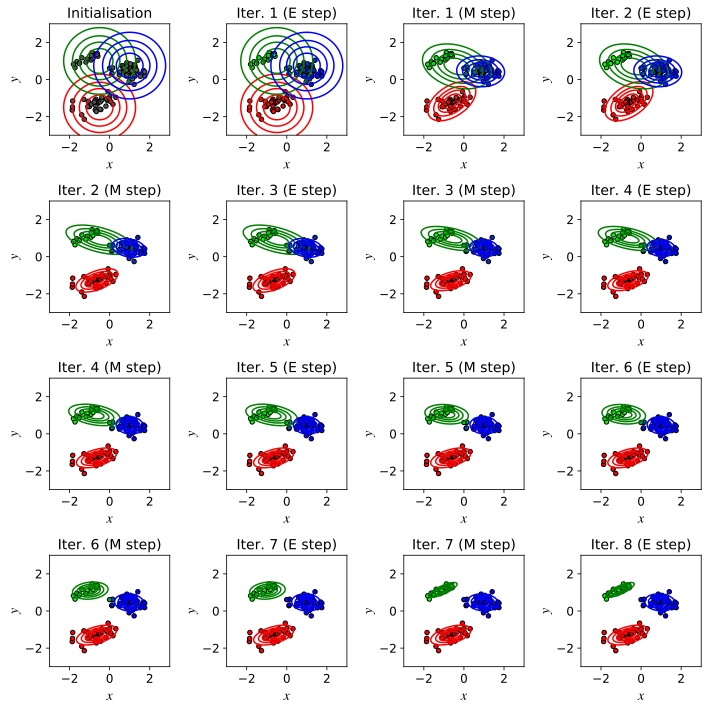

In [9]:
x = np.load('clustering_2d.npy') # load the 2d clustering dataset
K = 3 
q_init = np.ones(shape = (x.shape[0], K))/K # initial responsibilities = 1/K
mu_init = [np.array([-0.5, -1.5]), np.array([-0.5, 1]), np.array([1, 0.75])] # initial means judged by eye
cov_init = np.stack([np.eye(2)]*K)  # initial covariances equal to identity
pi_init = np.ones(shape = (K,))/K # initial cluster probabilities = 1/K
xs = np.stack([x]*K, axis = 1) # stack K copies of the data to do arithmetic conveniently
max_steps = 8 # maximum number of EM steps

qs, mus, pis, covs, f_energies = mog_EM(x, K, q_init, mu_init, pi_init, cov_init, max_steps) # apply EM


x_, y_ = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 250)) # x, y where to evaluate gaussians
grid = np.stack([x_, y_], axis = -1) # x, y grid to use for calculation of gaussians
colors = ['red', 'green', 'blue']

plt.figure(figsize = (10, 10))
for i in range(2*max_steps):
    
    plt.subplot(4, 4, i + 1)
    q, mu, pi, cov = qs[i], mus[i], pis[i], covs[i] # parameters of the i^th EM step
    
    for k in range(K):
        mu_, cov_ = mu[k], cov[k] # mean/covariance of the k^th gaussian cluster

        exp_ = np.exp(-0.5*np.sum((grid - mu_).dot(np.linalg.inv(cov_))*(grid - mu_),
                                  axis = -1)) # evaluate the k^th gaussian on the grid
        plt.contour(x_, y_, exp_, 4, colors = colors[k]) # plot the gaussian

    plt.scatter(x[:, 0], x[:, 1], s = 20, c = q.T, edgecolor = 'black') # show data, coloured by membership q
    beautify_plot({"title":"Iter. {} ({} step)".format((i+1)//2, 'EM'[(i + 1)%2]), "x":"$x$", "y":"$y$"})
    if i == 0:
        plt.title('Initialisation')
    plt.xticks([-2, 0, 2]), plt.yticks([-2, 0, 2])
    
    
plt.tight_layout()
plt.show()

In this plot, each gaussian cluster is shown with a different colour. Each of the datapoints is coloured according to the cluster responsibilities for this point, by setting its colour to be $(R, G, B) = q(s_n = 1), q(s_n = 2), q(s_n = 3)$. Initially, all points are gray (step $0$) because responsibilities are initialised as $q(\mathbf{s}_n = k) = 1/K,$ and the gaussians are isotropic as specified in the initialisation. During the first E step, the cluster responsibilities for each point change, but the gaussians' shape does not. Points which lie well inside one gaussian but outside another have a clear red, green or blue colour, whereas contested points lying between two gaussians have a mixed colour indicating the uncertainty about their cluster. Subsequently, in the M step, the gaussians change shape, whilst the points retain the same colour. The gaussians change shape as they reajust to accomodate the points they are responsible for, becoming narrower in this case. This process is repeated in subsequent EM steps, with datapoints being reallocated whilst keeping the gaussian shape fixed in the E step, followed by an adjustment of the gaussians to accommodate the reallocated points in the M step. Eventually the process seems to have converged to a satisfactory clustering. **How to judge convergence of EM**?

Now that we've demonstrated that EM can be used successfully for MoG, we return to our previous questions about global/local maxima. In particular, we want to answer whether there is a global maximum to the MoG problem, and whether EM is guaranteed to converge. To answer the first question, consider doing EM on the same dataset, only using a different initialisation, where the initial means are permuted:

<img src="clust_permuted_mog_1.svg" alt="Snow" style="width:60%; float: center; padding:0px">
<img src="clust_permuted_mog_2.svg" alt="Snow" style="width:60%; float: center; padding:0px">
<img src="clust_permuted_mog_3.svg" alt="Snow" style="width:60%; float: center; padding:0px">

In this case we obtain a solution which is the same as before, except the identities of the clusters are permuted. Although this is sufficient to show that there are several maxima in MoG, one could argue that this example is trivial because the points are ultimately clustered in the same groups, and ask whether there are local minima which are fundamentally different from each other. It turns out this is the case, as seen in the example below:

In [ ]:
q_init = np.ones(shape = (x.shape[0], K))/K # initial responsibilities = 1/K
mu_init = [np.array([-0.5, -1]), np.array([0, 0]), np.array([0.5, 0])] # initial means judged by eye
cov_init = np.stack([np.eye(2)*0.05, np.eye(2)*4, np.eye(2)]) # initial covariances isotropic but with different widths
pi_init = np.ones(shape = (K,))/K # initial cluster probabilities = 1/K
xs = np.stack([x]*K, axis = 1) # stack K copies of the data to do arithmetic conveniently
max_steps = 10 # maximum number of EM steps

qs, mus, pis, covs, f_energies = mog_EM(x, K, q_init, mu_init, pi_init, cov_init, max_steps) # apply EM

x_, y_ = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 250)) # x, y where to evaluate gaussians
grid = np.stack([x_, y_], axis = -1) # x, y grid to use for calculation of gaussians
colors = ['red', 'green', 'blue']

plt.figure(figsize = (10, 12))
for i in range(2*max_steps):
    
    plt.subplot(5, 4, i + 1)
    q, mu, pi, cov = qs[i], mus[i], pis[i], covs[i] # parameters of the i^th EM step
    
    for k in range(K):
        mu_, cov_ = mu[k], cov[k] # mean/covariance of the k^th gaussian cluster

        exp_ = np.exp(-0.5*np.sum((grid - mu_).dot(np.linalg.inv(cov_))*(grid - mu_),
                                  axis = -1)) # evaluate the k^th gaussian on the grid
        plt.contour(x_, y_, exp_, 4, colors = colors[k]) # plot the gaussian

    plt.scatter(x[:, 0], x[:, 1], s = 20, c = q.T, edgecolor = 'black') # show data, coloured by membership q
    beautify_plot({"title":"Iter. {} ({} step)".format((i+1)//2, 'EM'[(i + 1)%2]), "x":"$x$", "y":"$y$"})
    if i == 0:
        plt.title('Initialisation')
    plt.xticks([-2, 0, 2]), plt.yticks([-2, 0, 2])
    remove_axes(subplot = (5, 4, i + 1))
    
plt.tight_layout()
plt.show()